See [fast_wcs_interp_torch_experiments](fast_wcs_interp_torch_experiments.ipynb) for previous part

In [1]:
from pathlib import Path
#import psutil
#import pickle

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Data loading

In [3]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [4]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [5]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [6]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [7]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [8]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-04-01 17:37:27,693 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [9]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [10]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

### Cuda/torch preliminaries

In [11]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [12]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [13]:
primary_datatype = torch.float32
def dconvert(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=primary_datatype)

In [14]:
param_simplers = 'lambda,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans_3feature(urand):
    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1)
    do = (urand[2]*2 - 1)
    
    return l,ro << u.arcsec,do << u.arcsec

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch_3feature(rng, batch_size):
    l, ro, do = ptrans_3feature(rng.random(size=(len(param_simplers), batch_size)))
    l0 = l

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = np.array(slit.meta.wcs.world_to_pixel(sc, l0))
    ins = np.array([l.value, ro.value, do.value])

    return dconvert(ins).T, dconvert(outs).T

[t.shape for t in make_batch_3feature(np.random.default_rng(), 100)]

[torch.Size([100, 3]), torch.Size([100, 2])]

In [15]:
def make_grid_3feature(sizes, flatten=False):
    mingrids = ptrans_3feature([0 for _ in sizes])
    maxgrids = ptrans_3feature([1 for _ in sizes])
    mgrids = [np.linspace(*e) for e in zip(mingrids, maxgrids, sizes)]
    l, ro, do = np.meshgrid(*mgrids)

    sc = base_sc.spherical_offsets_by(ro, do)
    outs = dconvert(slit.meta.wcs.world_to_pixel(sc, l))

    ins = dconvert((l.value, ro.value, do.value))

    ins = ins.permute(*np.roll(range(len(ins.shape)), -1))
    outs = outs.permute(*np.roll(range(len(outs.shape)), -1))

    if flatten:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])
    
    return ins, outs

valid_ins, valid_outs = make_grid_3feature((100,100,100))
valid_ins_plot, valid_outs_plot = make_grid_3feature((100,10,10), flatten=True)
valid_ins.shape, valid_ins_plot.shape, valid_ins.shape, valid_outs_plot.shape

/tmp/ipykernel_1087/3779681214.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return cons(x).to(torch_device, dtype=primary_datatype)


(torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 3]),
 torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 2]))

In [16]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, in_n, out_n, inner_layer_nneurons=32, rectifier=None, batchnorm=False):
        super().__init__()

        if rectifier is None:
            self.rectifier = nn.GELU()
        else:
            self.rectifier = rectifier

        stack = [nn.Linear(in_n, inner_layer_nneurons),
                 nn.BatchNorm1d(inner_layer_nneurons) if batchnorm else None,
                 self.rectifier,
                 nn.Linear(inner_layer_nneurons, out_n)]
        
        self.stack = nn.Sequential(*[s for s in stack if s is not None])

    @property
    def in_n(self):
        return self.stack[0].in_features

    @property
    def out_n(self):
        return self.stack[-1].out_features
        
    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        y = self.stack(xflat)
        assert y.shape[-1] == self.out_n
        return y.reshape(*leading_dims, self.out_n)

model = SimpleNeuralNetwork(3, 2).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

# Training Functions

In [17]:
def batch_train(model, batch_size, n_batches, log_period=500, seed=42, optimizer=None, loss_fcn=None, valid_ins=valid_ins, valid_outs=valid_outs):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)
        

    
    batchi_test = []
    loss_test = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):
        inb, outb = data_gen(rng, batch_size)
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
            model.train()
        
    model.eval()
    return model, batchi_test, loss_test

In [18]:
def batch_train_pregen(model, batch_size, n_batches, log_period=500, seed=42, optimizer=None, loss_fcn=None, valid_ins=valid_ins, valid_outs=valid_outs):
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)

    ins, outs = make_batch_3feature(rng, batch_size*pregen)
    ins = ins.reshape(pregen, batch_size, ins.shape.numel()//pregen//batch_size)
    outs = outs.reshape(pregen, batch_size, outs.shape.numel()//pregen//batch_size)
    
    batchi_test = []
    loss_test = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):                
        inb = ins[batchi]
        outb = outs[batchi]
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
            model.train()
        
    model.eval()
    return model, batchi_test, loss_test

In [19]:
def batch_train_manygen(model, batch_size, n_batches, log_period=500, seed=42, optimizer=None, loss_fcn=None, pregen=False, valid_ins=valid_ins, valid_outs=valid_outs):
    #pregen is how many batches to generate at once
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)

    pregen = int(pregen)
    
    batchi_test = []
    loss_test = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):
        if batchi % pregen == 0:
            ins, outs = make_batch_3feature(rng, batch_size*pregen)
            ins = ins.reshape(pregen, batch_size, ins.shape.numel()//pregen//batch_size)
            outs = outs.reshape(pregen, batch_size, outs.shape.numel()//pregen//batch_size)
            
        inb = ins[batchi % pregen]
        outb = outs[batchi % pregen]
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
            model.train()
        
    model.eval()
    return model, batchi_test, loss_test

In [20]:
def batch_train_resample(model, batch_size, n_batches, npregen, log_period=500, seed=42, optimizer=None, loss_fcn=None, valid_ins=valid_ins, valid_outs=valid_outs, perm=True, lrsched=None):
    """pregen is a number of samples.  must be larger than n_batches, and each batch will sample a random permutation."""
    assert batch_size <= npregen
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)
    if lrsched is not None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrsched)
        llr = 0

    ins, outs = make_batch_3feature(rng, npregen)
    idxs = np.arange(npregen)
    
    batchi_test = []
    loss_test = []
    lr_update = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):
        if perm:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(npregen, size=batch_size)

        samples_t = torch.from_numpy(samples).to(torch_device)
            
        inb = ins[samples_t]
        outb = outs[samples_t]
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                print('test loss at batch', batchi, 'is', loss_test[-1])
                if lrsched is not None:
                    scheduler.step(loss_test[-1])
                    if llr != scheduler.get_last_lr():
                        llr = scheduler.get_last_lr()
                        print('lr updated to', llr)
                        lr_update.append(batchi)
            model.train()
        
    model.eval()
    return model, batchi_test, loss_test

In [21]:
def plot_model_run(model, batchis, losses, points_to_cut=1, valid_ins=valid_ins, valid_outs=valid_outs):
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax1.axhline(0, color='k', alpha=.5)
    
    ax2.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax2.semilogy()

    return fig

def plot_model_results(model, X=valid_ins_plot, Y=valid_outs_plot, maxpoints=None, **plotkwargs):
    with torch.no_grad():
        pred = model(X)
        diff = (pred - Y).cpu().detach().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    

    if maxpoints is None:
        slc = slice(None)
    else:
        slc = np.random.permutation(valid_outs_flat.shape[0])[:maxpoints]

    p = pred.cpu().detach().numpy()[slc]
    v = Y.cpu().detach().numpy()[slc]

    plotkwargs.setdefault('marker', 'o')
    plotkwargs.setdefault('linewidth', 0)
    plotkwargs.setdefault('markeredgewidth', 0)
    
    
    ax1.plot(p[:, 0], **plotkwargs, label='pred')
    ax1.plot(v[:, 0], **plotkwargs, label='validation')
    ax1.legend(loc=0)
    ax1.set_ylabel('x')
    
    ax2.plot(p[:, 1], **plotkwargs, label='pred')
    ax2.plot(v[:, 1], **plotkwargs, label='validation')
    ax2.legend(loc=0)
    ax2.set_ylabel('y')
        
    ax3.plot(diff[slc], **plotkwargs)
    ax3.set_ylabel('residuals')
    ax3.legend(['x', 'y'], loc=0)
        
    # ax4.plot(diff[slc, 0]/v[:, 0], **plotkwargs, label='x')
    # ax4.plot(diff[slc, 1]/v[:, 1], **plotkwargs, label='y')
    # ax4.set_ylabel('frac residuals')
    # ax4.set_ylim(-2,2)
    # ax4.legend(loc=0)
    
    return fig


# Test Runs

In [19]:
%%time

res = batch_train_pregen(SimpleNeuralNetwork(3, 2), 1024, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

test loss at batch 0 is 2575978.5
test loss at batch 99 is 115234.7578125
CPU times: user 547 ms, sys: 169 ms, total: 716 ms
Wall time: 505 ms


In [20]:
%%time

res = batch_train(SimpleNeuralNetwork(3, 2), 1024, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

test loss at batch 0 is 8062643.5
test loss at batch 99 is 115220.9609375
CPU times: user 12 s, sys: 5.35 s, total: 17.4 s
Wall time: 10.7 s


In [21]:
%%time

res = batch_train_pregen(SimpleNeuralNetwork(3, 2), 1024, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

test loss at batch 0 is 1150895.75
test loss at batch 500 is 115247.859375
test loss at batch 999 is 115223.3984375
CPU times: user 2.15 s, sys: 3.15 s, total: 5.3 s
Wall time: 1.49 s


In [22]:
%%time

res = batch_train_pregen(SimpleNeuralNetwork(3, 2), 1024, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

test loss at batch 0 is 4723954.5
test loss at batch 500 is 115155.9921875
test loss at batch 1000 is 115117.6015625
test loss at batch 1500 is 115145.8671875
test loss at batch 2000 is 115521.6796875
test loss at batch 2500 is 115207.2734375
test loss at batch 3000 is 115368.4609375
test loss at batch 3500 is 114882.6953125
test loss at batch 4000 is 115005.5546875
test loss at batch 4500 is 114860.5859375
test loss at batch 5000 is 114728.203125
test loss at batch 5500 is 114692.4140625
test loss at batch 6000 is 114746.8984375
test loss at batch 6500 is 114567.3359375
test loss at batch 7000 is 114521.453125
test loss at batch 7500 is 114518.2421875
test loss at batch 8000 is 114308.296875
test loss at batch 8500 is 114306.34375
test loss at batch 9000 is 114131.109375
test loss at batch 9500 is 114300.8671875
test loss at batch 9999 is 114145.4765625
CPU times: user 13.4 s, sys: 7.58 s, total: 21 s
Wall time: 15.1 s


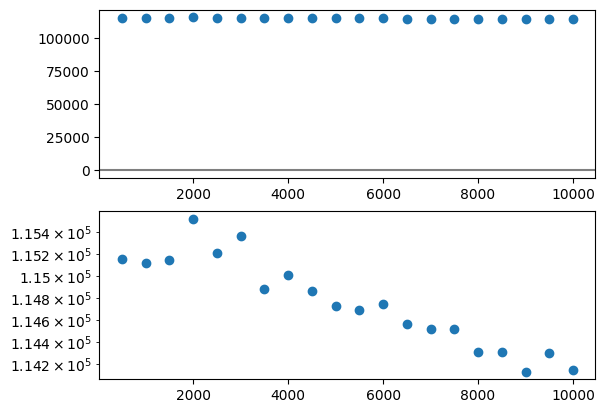

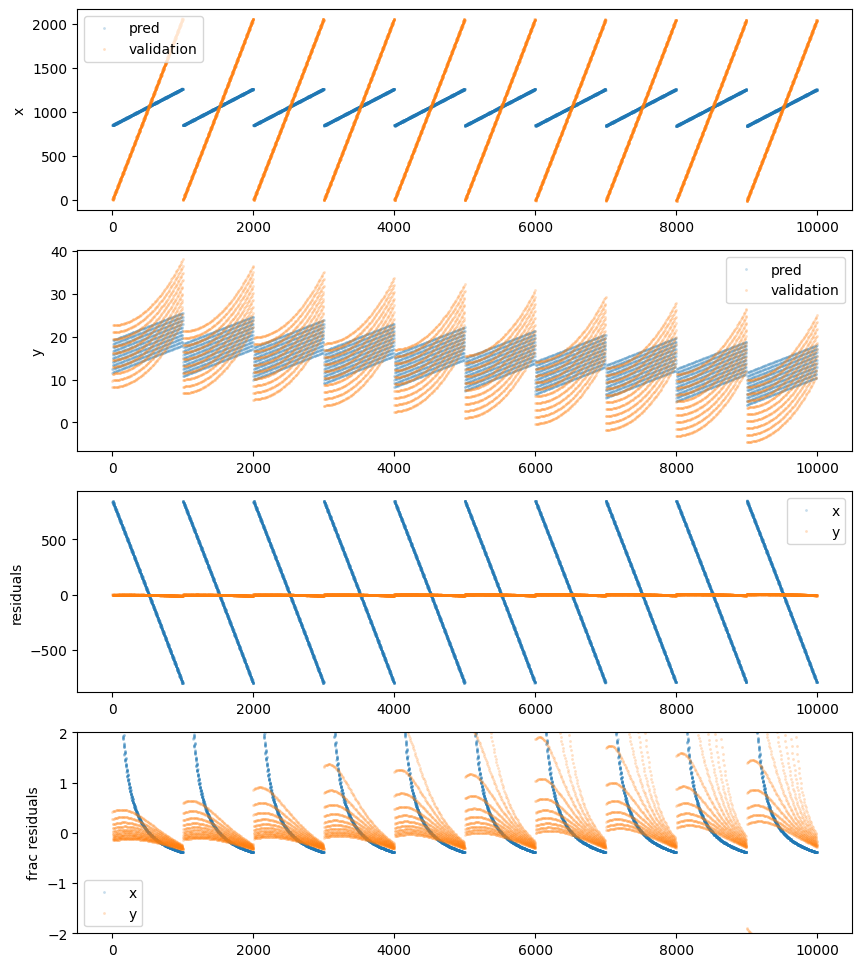

In [23]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [24]:
10000*1024*primary_datatype.itemsize*res[0].stack[0].out_features /1024/1024/1204 #space taken by one layer in the network in GB

1.0382059800664452

Above run took ~3 GB of memory

In [25]:
%%time

res = batch_train(SimpleNeuralNetwork(3, 2), 1024*100, 100, log_period=5)

  0%|          | 0/100 [00:00<?, ?it/s]

test loss at batch 0 is 2781601.25
test loss at batch 5 is 1822529.625
test loss at batch 10 is 1153613.125
test loss at batch 15 is 670470.0
test loss at batch 20 is 362367.03125
test loss at batch 25 is 201666.0625
test loss at batch 30 is 132045.734375
test loss at batch 35 is 115353.96875
test loss at batch 40 is 120735.3203125
test loss at batch 45 is 126423.8203125
test loss at batch 50 is 127739.28125
test loss at batch 55 is 124672.03125
test loss at batch 60 is 120256.90625
test loss at batch 65 is 117081.1953125
test loss at batch 70 is 115501.3984375
test loss at batch 75 is 115211.40625
test loss at batch 80 is 115354.75
test loss at batch 85 is 115486.65625
test loss at batch 90 is 115449.0390625
test loss at batch 95 is 115336.9765625
test loss at batch 99 is 115257.296875
CPU times: user 21.3 s, sys: 8.17 s, total: 29.5 s
Wall time: 14.2 s


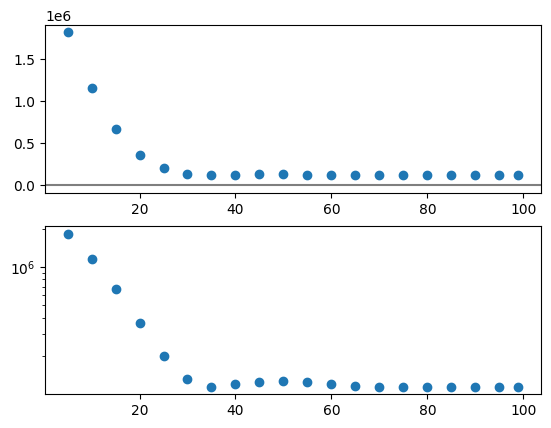

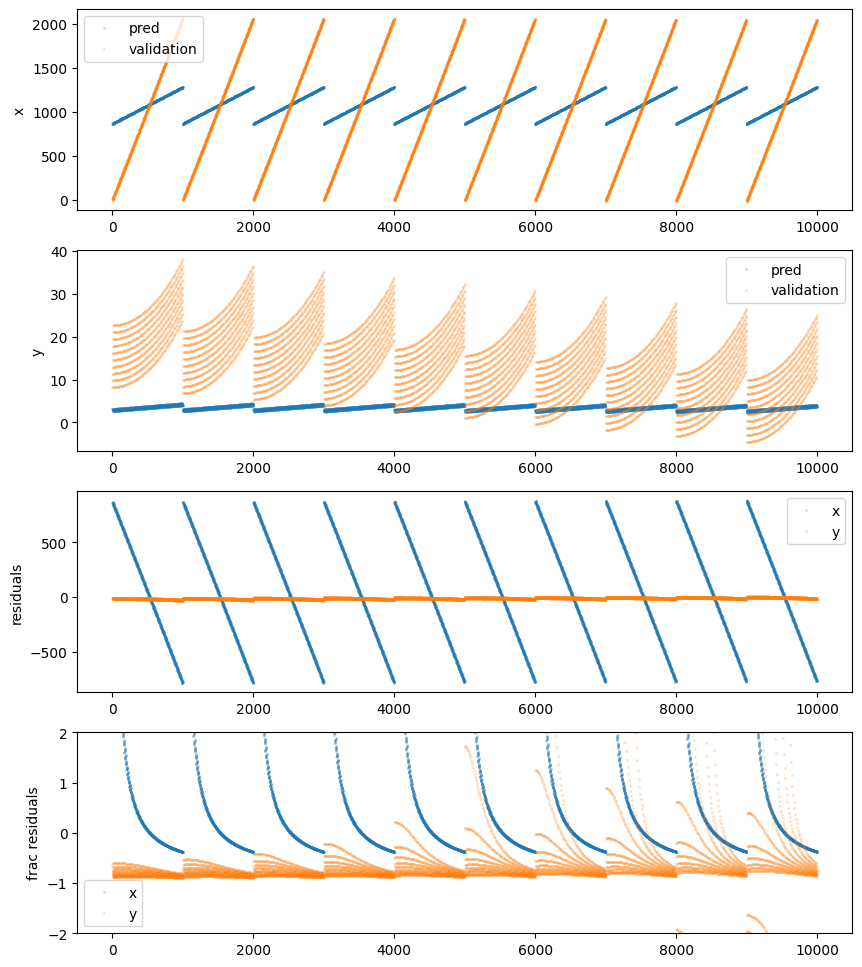

In [26]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [27]:
%%time

res = batch_train_pregen(SimpleNeuralNetwork(3, 2, batchnorm=True), 1024, 10000, log_period=500)

  0%|          | 0/10000 [00:00<?, ?it/s]

test loss at batch 0 is 688778.125
test loss at batch 500 is 662950.1875
test loss at batch 1000 is 611290.125
test loss at batch 1500 is 489069.40625
test loss at batch 2000 is 417576.78125
test loss at batch 2500 is 241745.71875
test loss at batch 3000 is 195506.578125
test loss at batch 3500 is 107413.46875
test loss at batch 4000 is 42794.6875
test loss at batch 4500 is 39832.34765625
test loss at batch 5000 is 19224.79296875
test loss at batch 5500 is 14355.7802734375
test loss at batch 6000 is 6836.32958984375
test loss at batch 6500 is 11055.740234375
test loss at batch 7000 is 2231.2109375
test loss at batch 7500 is 8321.5927734375
test loss at batch 8000 is 2445.0380859375
test loss at batch 8500 is 8949.5380859375
test loss at batch 9000 is 10512.2255859375
test loss at batch 9500 is 24580.80078125
test loss at batch 9999 is 684.2783813476562
CPU times: user 14.3 s, sys: 7.76 s, total: 22.1 s
Wall time: 16.2 s


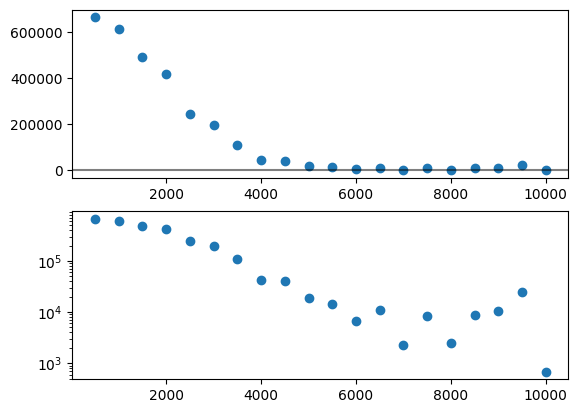

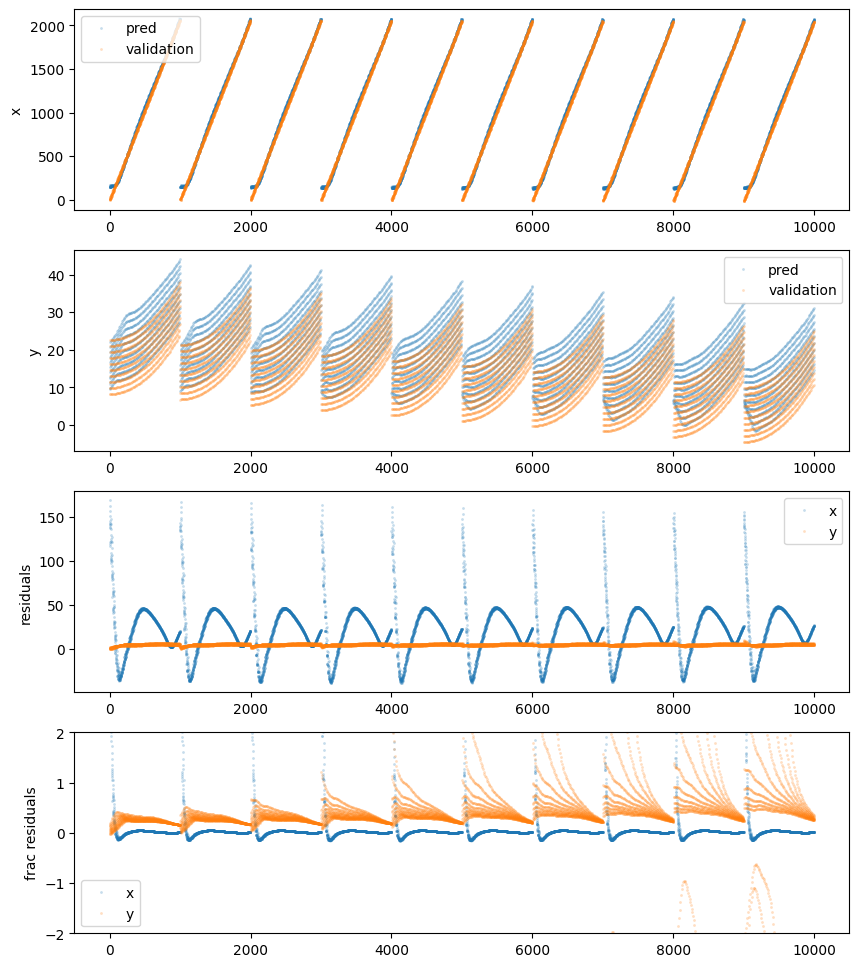

In [28]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [29]:
%%time

res = batch_train_manygen(SimpleNeuralNetwork(3, 2, batchnorm=True), 1024*10, 10000, pregen=1000, log_period=250)

  0%|          | 0/10000 [00:00<?, ?it/s]

test loss at batch 0 is 690882.625
test loss at batch 250 is 688444.0
test loss at batch 500 is 658530.25
test loss at batch 750 is 631709.375
test loss at batch 1000 is 579767.25
test loss at batch 1250 is 514959.0
test loss at batch 1500 is 476807.4375
test loss at batch 1750 is 421509.78125
test loss at batch 2000 is 363501.28125
test loss at batch 2250 is 320791.875
test loss at batch 2500 is 270552.34375
test loss at batch 2750 is 229615.859375
test loss at batch 3000 is 179200.15625
test loss at batch 3250 is 159178.5625
test loss at batch 3500 is 119565.046875
test loss at batch 3750 is 88923.7578125
test loss at batch 4000 is 59542.82421875
test loss at batch 4250 is 59956.75
test loss at batch 4500 is 44810.4375
test loss at batch 4750 is 36169.5
test loss at batch 5000 is 15110.4453125
test loss at batch 5250 is 24740.916015625
test loss at batch 5500 is 6824.77978515625
test loss at batch 5750 is 7265.71923828125
test loss at batch 6000 is 6072.3310546875
test loss at batch 

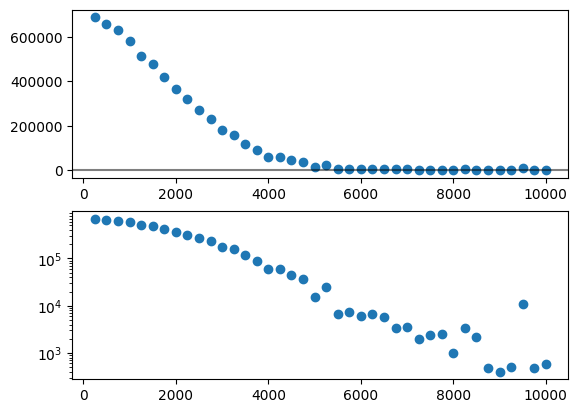

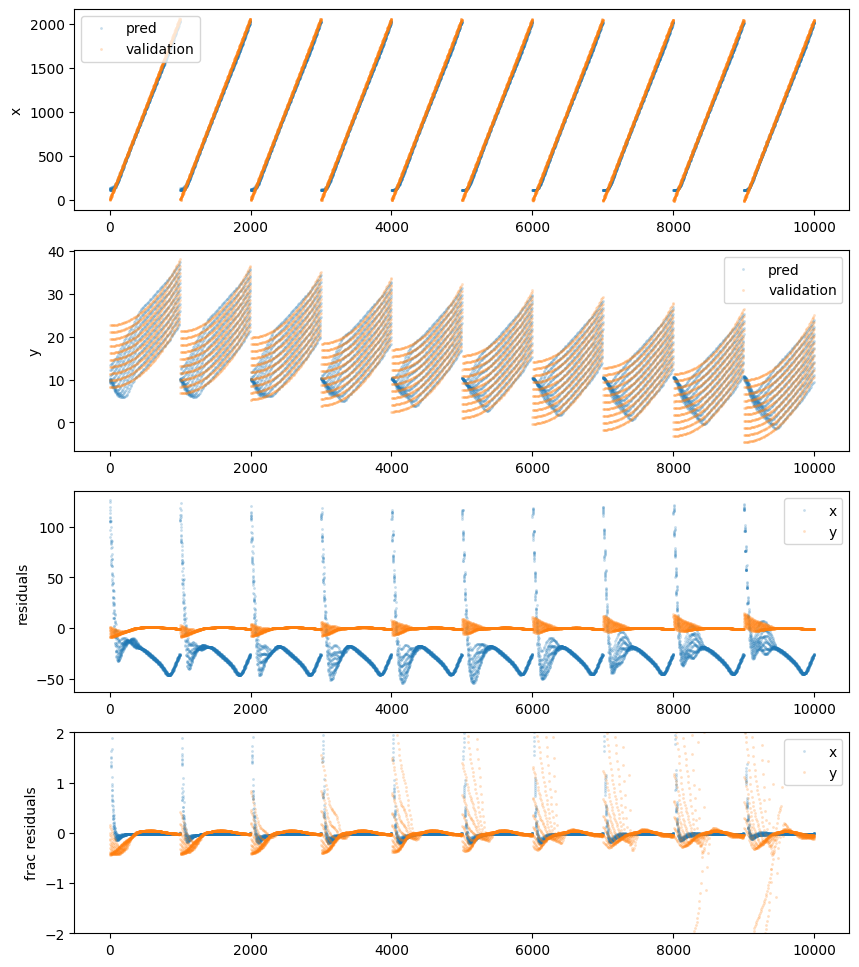

In [30]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [31]:
%%time

res = batch_train_manygen(SimpleNeuralNetwork(3, 2, batchnorm=True), 1024*5, 500000, pregen=5000, log_period=1000)

  0%|          | 0/500000 [00:00<?, ?it/s]

test loss at batch 0 is 688205.0625
test loss at batch 1000 is 575708.0625
test loss at batch 2000 is 363847.40625
test loss at batch 3000 is 209068.5625
test loss at batch 4000 is 34606.11328125
test loss at batch 5000 is 17979.818359375
test loss at batch 6000 is 8752.912109375
test loss at batch 7000 is 7241.05908203125
test loss at batch 8000 is 1206.264404296875
test loss at batch 9000 is 1289.1627197265625
test loss at batch 10000 is 940.4178466796875
test loss at batch 11000 is 7877.60693359375
test loss at batch 12000 is 4653.978515625
test loss at batch 13000 is 1313.5570068359375
test loss at batch 14000 is 4739.70556640625
test loss at batch 15000 is 10667.1162109375
test loss at batch 16000 is 6878.90185546875
test loss at batch 17000 is 533.6005859375
test loss at batch 18000 is 95.66997528076172
test loss at batch 19000 is 11431.6455078125
test loss at batch 20000 is 243.1748809814453
test loss at batch 21000 is 8374.1533203125
test loss at batch 22000 is 2044.62255859375

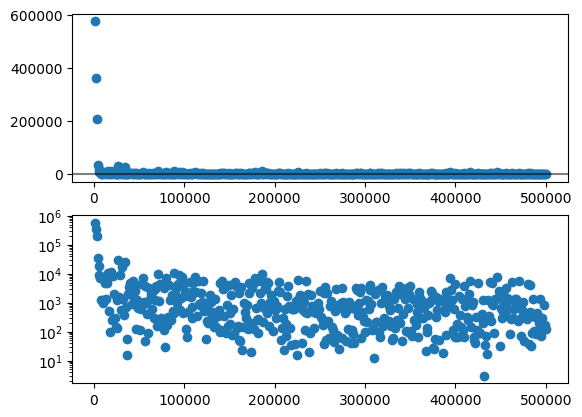

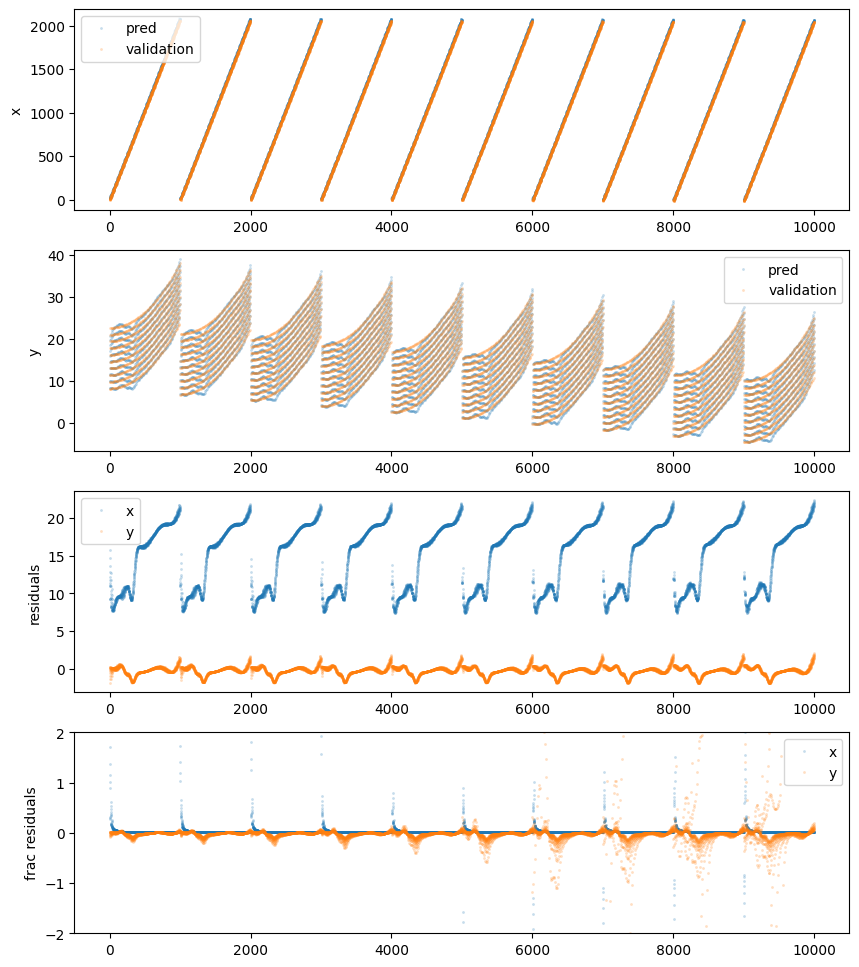

In [32]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [40]:
%%time

res = batch_train_manygen(SimpleNeuralNetwork(3, 2, batchnorm=True, inner_layer_nneurons=64), 1024*20, 50000, pregen=1000, log_period=500)

  0%|          | 0/50000 [00:00<?, ?it/s]

test loss at batch 0 is 684975.0
test loss at batch 500 is 617386.4375
test loss at batch 1000 is 477970.21875
test loss at batch 1500 is 301552.8125
test loss at batch 2000 is 169406.953125
test loss at batch 2500 is 67282.2265625
test loss at batch 3000 is 44242.82421875
test loss at batch 3500 is 16567.82421875
test loss at batch 4000 is 7822.7802734375
test loss at batch 4500 is 5777.5791015625
test loss at batch 5000 is 3557.520263671875
test loss at batch 5500 is 2378.746826171875
test loss at batch 6000 is 1423.6871337890625
test loss at batch 6500 is 3186.63427734375
test loss at batch 7000 is 2801.031494140625
test loss at batch 7500 is 2023.9775390625
test loss at batch 8000 is 290.2998962402344
test loss at batch 8500 is 376.9866943359375
test loss at batch 9000 is 213.24441528320312
test loss at batch 9500 is 25820.056640625
test loss at batch 10000 is 137.4332733154297
test loss at batch 10500 is 606.2588500976562
test loss at batch 11000 is 1244.747314453125
test loss at 

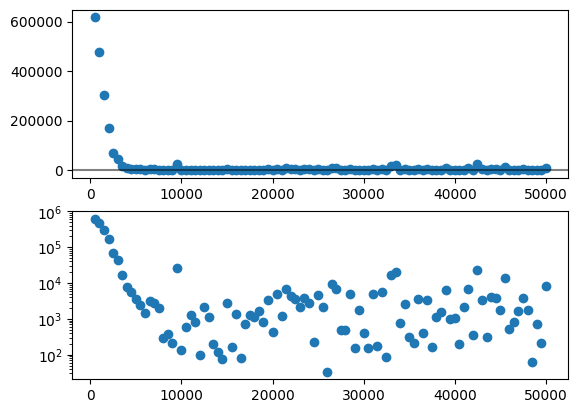

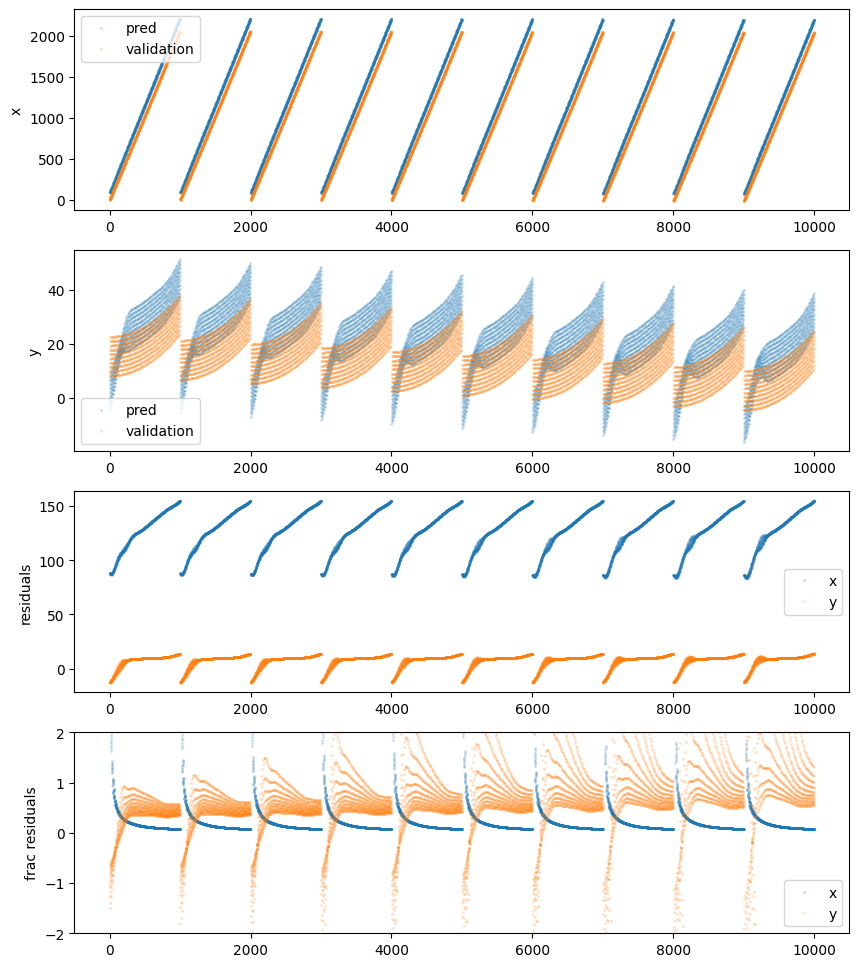

In [41]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [38]:
%%time

res = batch_train_manygen(SimpleNeuralNetwork(3, 2, batchnorm=True, inner_layer_nneurons=128), 1024*10, 50000, pregen=2000, log_period=500)

  0%|          | 0/50000 [00:00<?, ?it/s]

test loss at batch 0 is 674421.625
test loss at batch 500 is 549409.0625
test loss at batch 1000 is 279274.09375
test loss at batch 1500 is 99279.2421875
test loss at batch 2000 is 43747.58203125
test loss at batch 2500 is 18916.287109375
test loss at batch 3000 is 9366.3173828125
test loss at batch 3500 is 4491.6728515625
test loss at batch 4000 is 2464.037353515625
test loss at batch 4500 is 1338.419677734375
test loss at batch 5000 is 1265.1041259765625
test loss at batch 5500 is 1426.7906494140625
test loss at batch 6000 is 2962.0556640625
test loss at batch 6500 is 1122.446044921875
test loss at batch 7000 is 2873.284912109375
test loss at batch 7500 is 329.7716369628906
test loss at batch 8000 is 199.45184326171875
test loss at batch 8500 is 1218.4346923828125
test loss at batch 9000 is 200.5823211669922
test loss at batch 9500 is 226.50376892089844
test loss at batch 10000 is 57.95956039428711
test loss at batch 10500 is 226.57620239257812
test loss at batch 11000 is 620.2844238

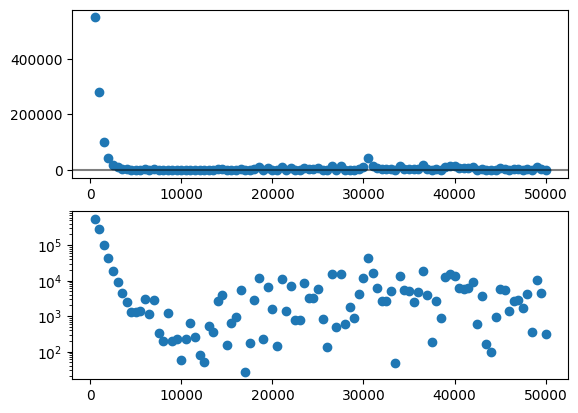

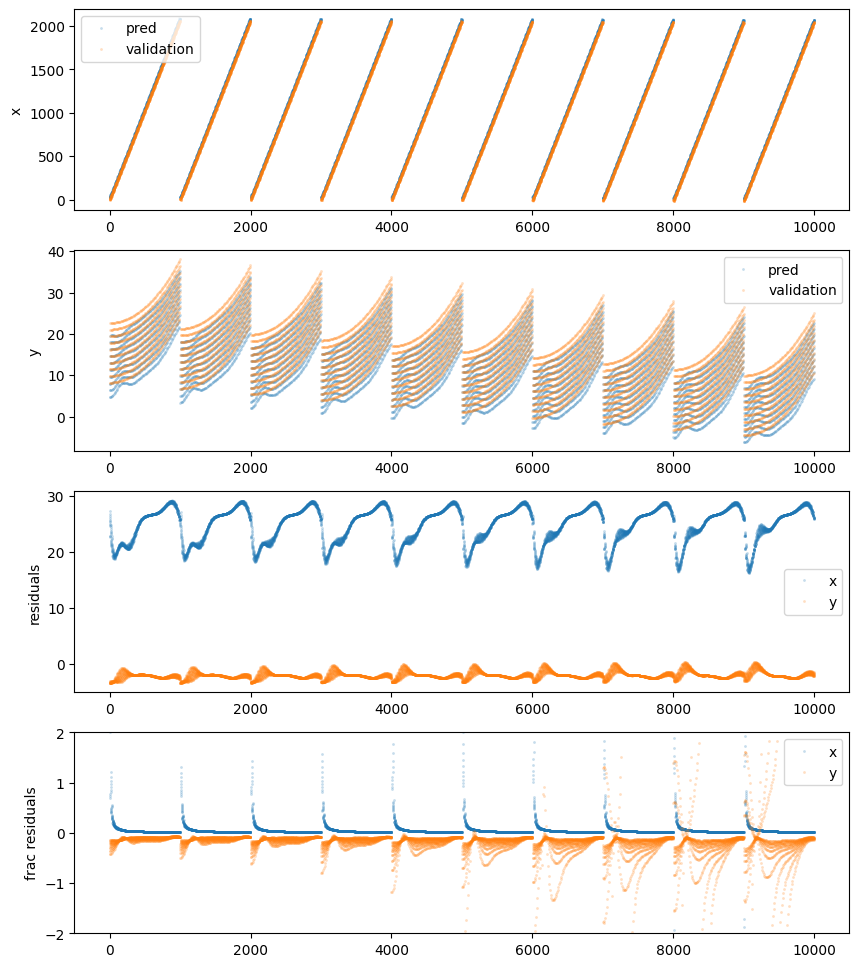

In [39]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [79]:
%%time

res = batch_train_resample(SimpleNeuralNetwork(3, 2, batchnorm=True, inner_layer_nneurons=64), 1024*25, 250000, log_period=2500, npregen=1024*500, perm=False)

  0%|          | 0/250000 [00:00<?, ?it/s]

test loss at batch 0 is 677748.8125
test loss at batch 2500 is 89359.65625
test loss at batch 5000 is 6468.5263671875
test loss at batch 7500 is 1030.572509765625
test loss at batch 10000 is 423.4171142578125
test loss at batch 12500 is 2367.18896484375
test loss at batch 15000 is 119.4665298461914
test loss at batch 17500 is 343.21734619140625
test loss at batch 20000 is 1105.78173828125
test loss at batch 22500 is 519.3630981445312
test loss at batch 25000 is 2511.110107421875
test loss at batch 27500 is 167.92271423339844
test loss at batch 30000 is 2473.21142578125
test loss at batch 32500 is 1924.22265625
test loss at batch 35000 is 111.2238540649414
test loss at batch 37500 is 1425.8819580078125
test loss at batch 40000 is 966.6300048828125
test loss at batch 42500 is 2624.943603515625
test loss at batch 45000 is 4933.74365234375
test loss at batch 47500 is 391.5234375
test loss at batch 50000 is 5609.72265625
test loss at batch 52500 is 592.085205078125
test loss at batch 55000 

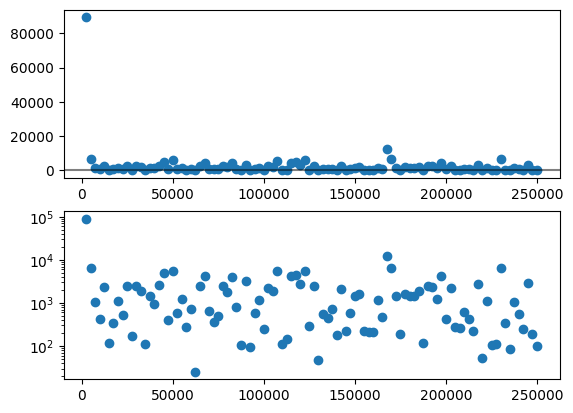

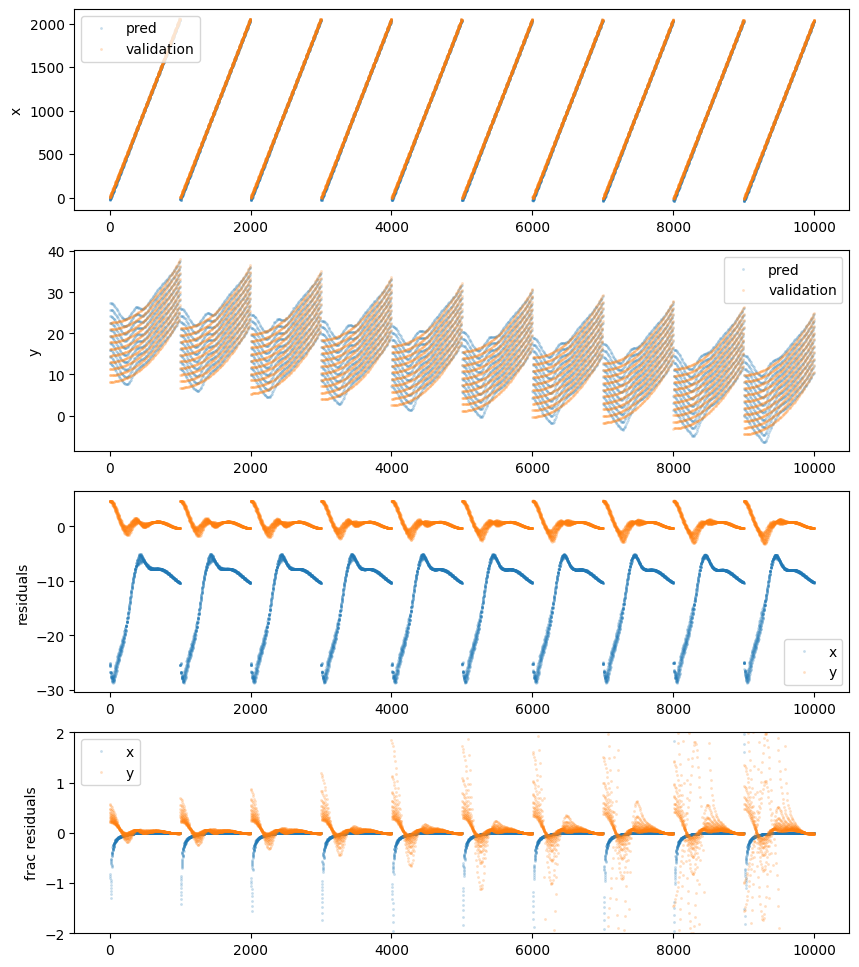

In [80]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

Well it just doesn't seem to be happy enough.  Will it do better if we 

## add a rescaling layer?

In [22]:
class RescalingNeuralNetwork(nn.Module):
    def __init__(self, inbounds, outbounds, inner_layer_nneurons=32, rectifier=None, batchnorm=False, endsmooth=False):
        """
        outbounds should be [(d1lower, d1upper), (d2lower, d2upper), etc...]
        """
        super().__init__()

        in_n = len(inbounds)
        self.inscale = dconvert([u-l for l, u in inbounds])
        self.inoffset = dconvert([l for l, u in inbounds])
        
        out_n = len(outbounds)
        self.outscale = dconvert([u-l for l, u in outbounds])
        self.outoffset = dconvert([l for l, u in outbounds])

        if rectifier is None:
            self.rectifier = nn.GELU()
        else:
            self.rectifier = rectifier

        

        stack = [nn.Linear(in_n, inner_layer_nneurons),
                 nn.BatchNorm1d(inner_layer_nneurons) if batchnorm else None,  # should not be necessary but you never know...
                 self.rectifier,
                 last_linear := nn.Linear(inner_layer_nneurons, out_n),
                 nn.Tanh() if endsmooth else None]
        self.last_linear = last_linear
        
        self.stack = nn.Sequential(*[s for s in stack if s is not None])

    @property
    def in_n(self):
        return self.stack[0].in_features

    @property
    def out_n(self):
        return self.last_linear.out_features
        
    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        xflat_rescaled = (xflat - self.inoffset)/self.inscale
        y = self.stack(xflat_rescaled)
        assert y.shape[-1] == self.out_n
        # note this rescaling assumes y is on [-1, 1]
        hscale = self.outscale*0.5
        return y.reshape(*leading_dims, self.out_n) * hscale + (self.outoffset + hscale)

model = RescalingNeuralNetwork([(0,2), (-1, 2), (3,4)], [(0,2), (-1, 2)], batchnorm=True, endsmooth=True).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

In [127]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=32), 1024*10, 25000, log_period=2500, npregen=1024*100, perm=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

test loss at batch 0 is 738669.125
test loss at batch 2500 is 36.99560546875
test loss at batch 5000 is 3.4352853298187256
test loss at batch 7500 is 2.6744508743286133
test loss at batch 10000 is 1.8884050846099854
test loss at batch 12500 is 1.7082202434539795
test loss at batch 15000 is 2.063087224960327
test loss at batch 17500 is 1.4554117918014526
test loss at batch 20000 is 1.1914327144622803
test loss at batch 22500 is 0.5234774947166443
test loss at batch 24999 is 1.2278287410736084
CPU times: user 18.2 s, sys: 506 ms, total: 18.7 s
Wall time: 19.9 s


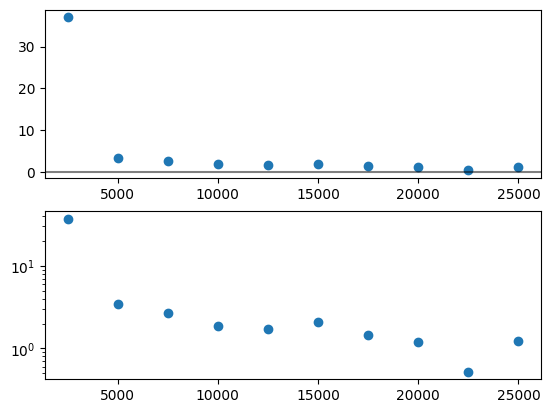

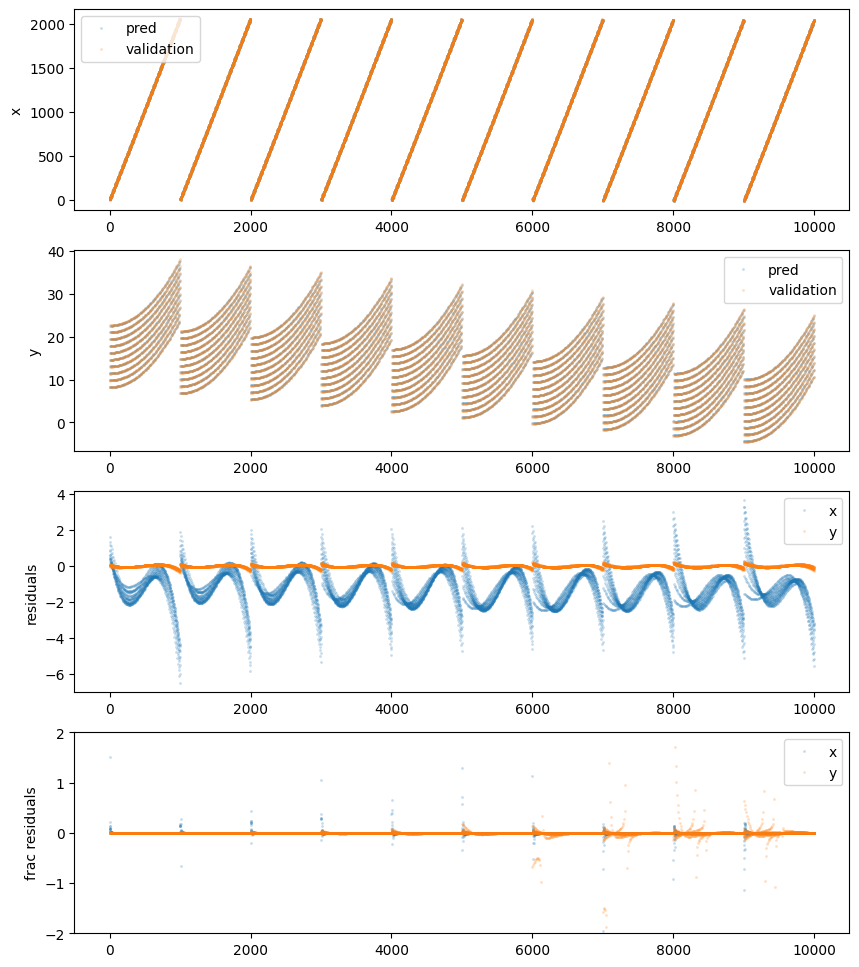

In [128]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

Wow ok that's a huge improvement... lets try some variations then.

In [141]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*25, 100000, log_period=2500, npregen=1024*1000, perm=False, optimizer=dict(lr=1e-4))

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 517437.46875
test loss at batch 2500 is 27.784748077392578
test loss at batch 5000 is 3.831881523132324
test loss at batch 7500 is 0.34128740429878235
test loss at batch 10000 is 0.276524156332016
test loss at batch 12500 is 0.1842886507511139
test loss at batch 15000 is 0.0779743418097496
test loss at batch 17500 is 0.0955914556980133
test loss at batch 20000 is 0.07313818484544754
test loss at batch 22500 is 0.031235745176672935
test loss at batch 25000 is 0.03224273771047592
test loss at batch 27500 is 0.1308896839618683
test loss at batch 30000 is 0.075299471616745
test loss at batch 32500 is 0.10107801854610443
test loss at batch 35000 is 0.05173615738749504
test loss at batch 37500 is 0.030083099380135536
test loss at batch 40000 is 0.019960720092058182
test loss at batch 42500 is 0.023789050057530403
test loss at batch 45000 is 0.016117487102746964
test loss at batch 47500 is 0.28409212827682495
test loss at batch 50000 is 0.009813687764108181
test loss a

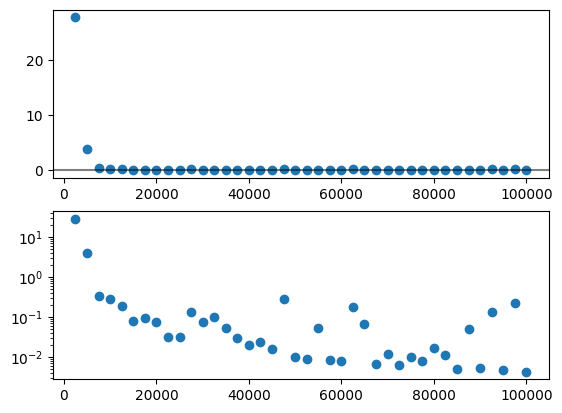

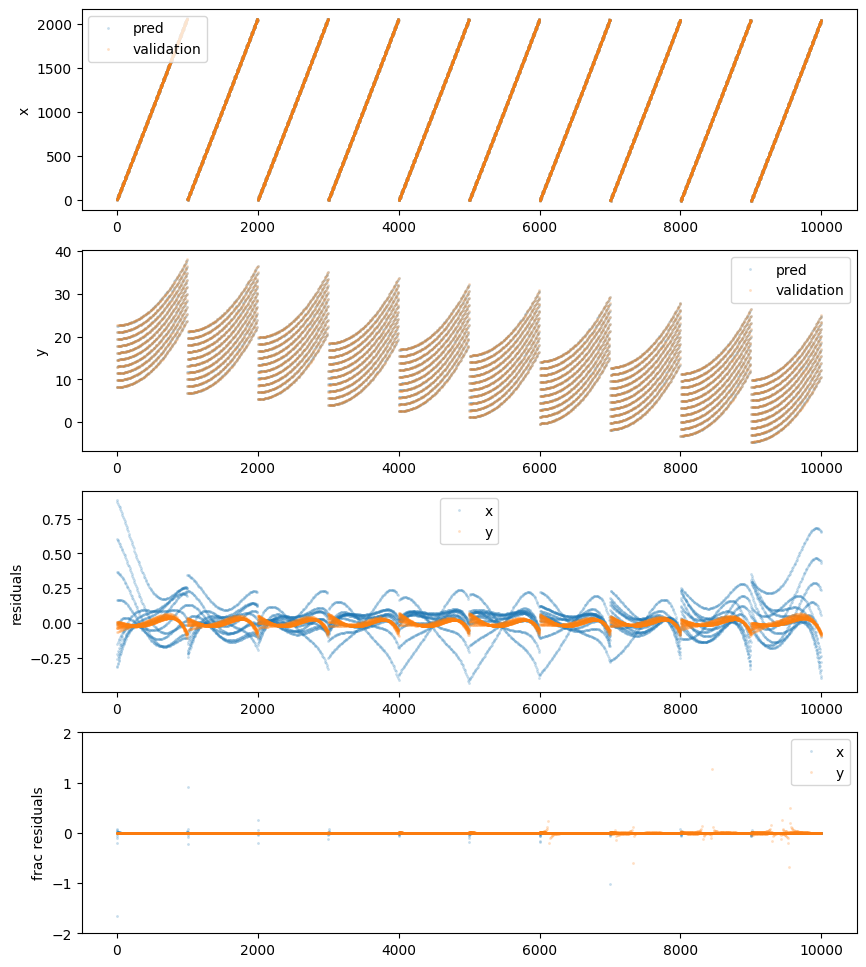

In [142]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [190]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*25, 250000, log_period=1000, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=5e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.2, 'threshold':.001})

  0%|          | 0/250000 [00:00<?, ?it/s]

test loss at batch 0 is 767007.9375
lr updated to [0.0005]
test loss at batch 1000 is 80.88655853271484
test loss at batch 2000 is 6.293491840362549
test loss at batch 3000 is 0.4840010106563568
test loss at batch 4000 is 0.28013312816619873
test loss at batch 5000 is 0.25144338607788086
test loss at batch 6000 is 0.21618470549583435
test loss at batch 7000 is 0.1729796975851059
test loss at batch 8000 is 0.12594497203826904
test loss at batch 9000 is 0.0915532037615776
test loss at batch 10000 is 0.1508772224187851
test loss at batch 11000 is 0.05141206458210945
test loss at batch 12000 is 0.3146943151950836
test loss at batch 13000 is 0.034188028424978256
test loss at batch 14000 is 0.030613437294960022
test loss at batch 15000 is 0.02519916370511055
test loss at batch 16000 is 0.023147722706198692
test loss at batch 17000 is 0.02876759134232998
test loss at batch 18000 is 0.04935687035322189
test loss at batch 19000 is 0.05172588303685188
test loss at batch 20000 is 0.34652924537658

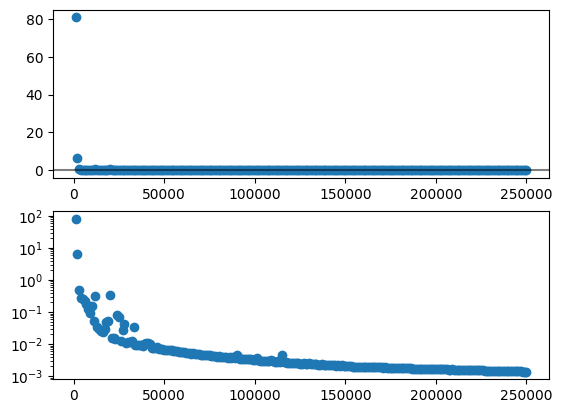

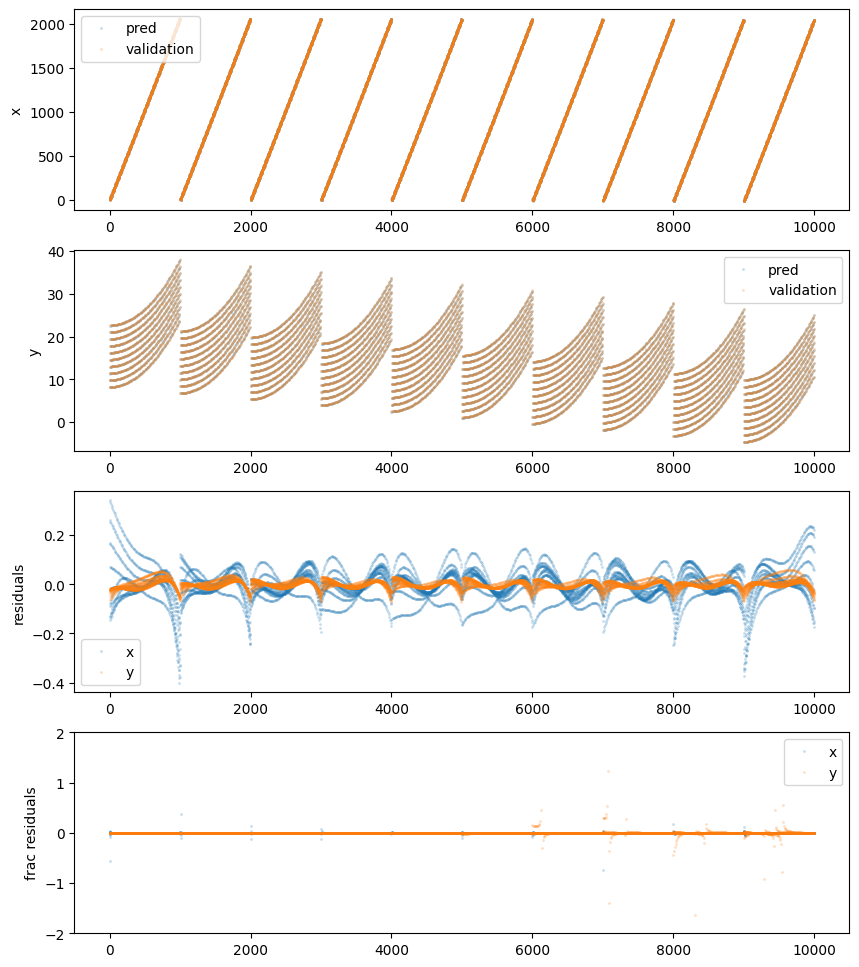

In [191]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

Experiment with L1 loss

In [192]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*25, 250000, log_period=1000, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=5e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.2, 'threshold':.001},
                           loss_fcn=nn.L1Loss())

  0%|          | 0/250000 [00:00<?, ?it/s]

test loss at batch 0 is 321.3529052734375
lr updated to [0.0005]
test loss at batch 1000 is 2.9671554565429688
test loss at batch 2000 is 1.8250089883804321
test loss at batch 3000 is 3.9625000953674316
test loss at batch 4000 is 2.1008176803588867
test loss at batch 5000 is 4.188939571380615
test loss at batch 6000 is 1.9176362752914429
lr updated to [0.0001]
test loss at batch 7000 is 0.45001569390296936
test loss at batch 8000 is 0.39673691987991333
test loss at batch 9000 is 0.35353225469589233
test loss at batch 10000 is 0.3568536043167114
test loss at batch 11000 is 0.2613743543624878
test loss at batch 12000 is 0.3431244492530823
test loss at batch 13000 is 0.2794193625450134
test loss at batch 14000 is 0.21661123633384705
test loss at batch 15000 is 0.2852189540863037
test loss at batch 16000 is 0.2705206871032715
test loss at batch 17000 is 0.1713888943195343
test loss at batch 18000 is 0.5861724019050598
test loss at batch 19000 is 0.778150737285614
test loss at batch 20000 i

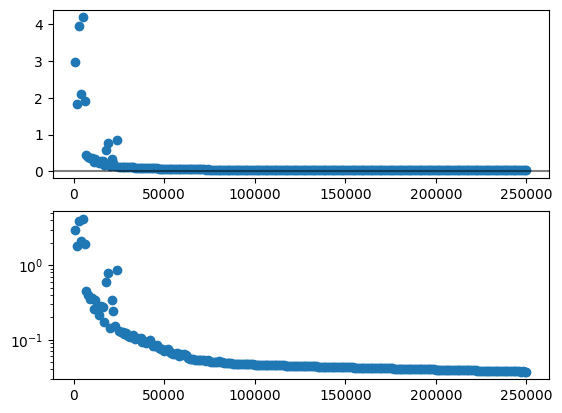

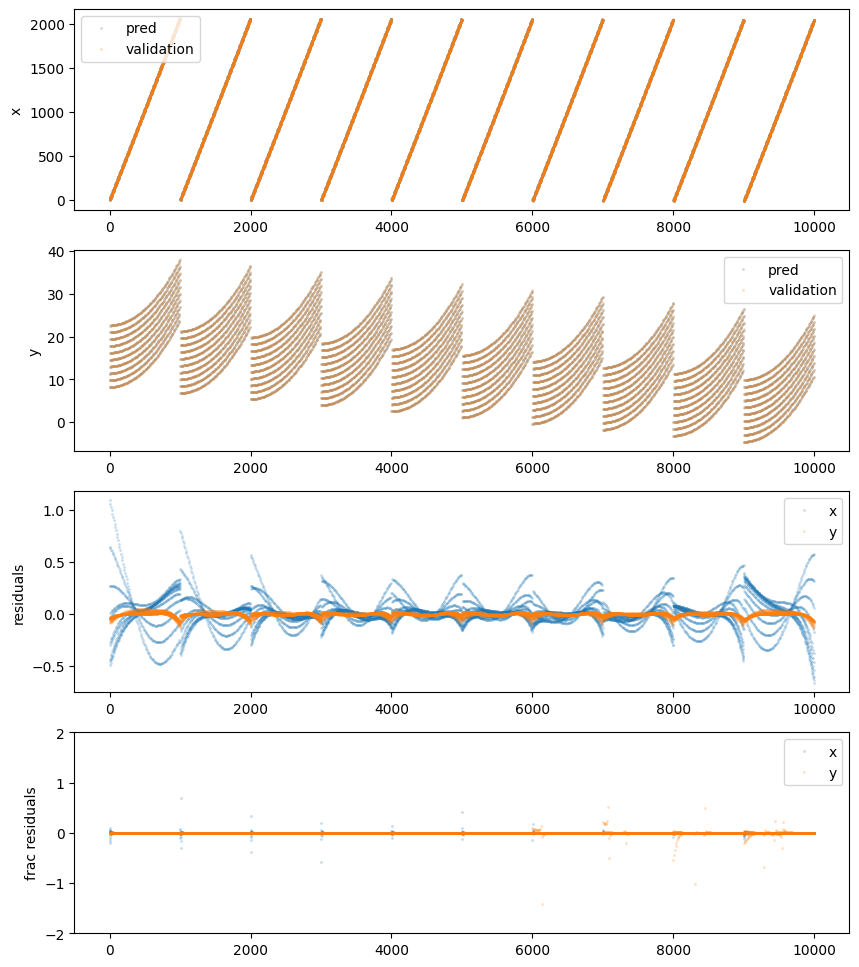

In [193]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

Nope.  What about just running longer?

In [26]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*25, 500000, log_period=1000, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=2e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001})

  0%|          | 0/500000 [00:00<?, ?it/s]

test loss at batch 0 is 586616.375
lr updated to [0.0002]
test loss at batch 1000 is 106.10860443115234
test loss at batch 2000 is 45.35771179199219
test loss at batch 3000 is 15.70754623413086
test loss at batch 4000 is 2.9961180686950684
test loss at batch 5000 is 0.6167036294937134
test loss at batch 6000 is 0.47257712483406067
test loss at batch 7000 is 0.4310680031776428
test loss at batch 8000 is 0.37566080689430237
test loss at batch 9000 is 0.301483690738678
test loss at batch 10000 is 0.21102115511894226
test loss at batch 11000 is 0.1576332300901413
test loss at batch 12000 is 0.09167773276567459
test loss at batch 13000 is 0.06075287610292435
test loss at batch 14000 is 0.03963182121515274
test loss at batch 15000 is 0.3980609178543091
test loss at batch 16000 is 0.022421160712838173
test loss at batch 17000 is 0.032178934663534164
test loss at batch 18000 is 0.014862509444355965
test loss at batch 19000 is 0.18446725606918335
test loss at batch 20000 is 0.08096297085285187


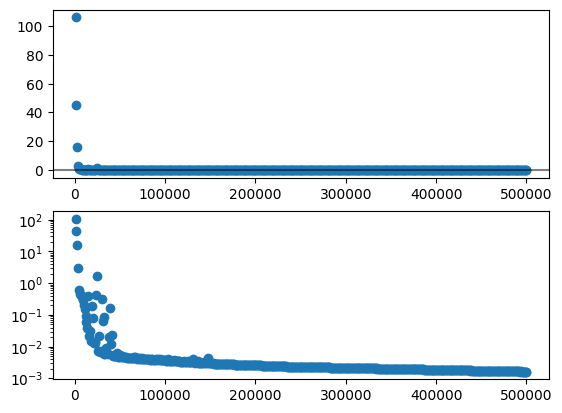

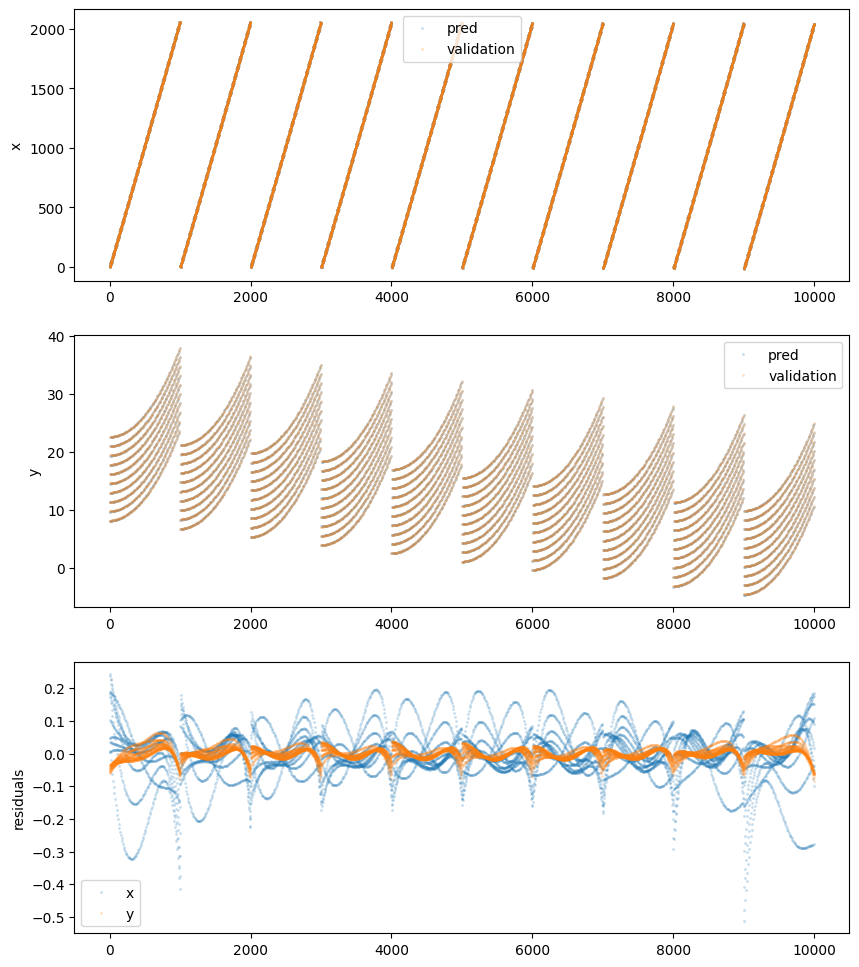

In [29]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [41]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*25, 100000, log_period=250, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=2e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001})

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 840941.75
lr updated to [0.0002]
test loss at batch 250 is 8286.6298828125
test loss at batch 500 is 228.10446166992188
test loss at batch 750 is 176.85951232910156
test loss at batch 1000 is 148.66143798828125
test loss at batch 1250 is 120.9201431274414
test loss at batch 1500 is 95.17440032958984
test loss at batch 1750 is 72.60444641113281
test loss at batch 2000 is 53.74274444580078
test loss at batch 2250 is 38.71421432495117
test loss at batch 2500 is 27.24467658996582
test loss at batch 2750 is 18.870031356811523
test loss at batch 3000 is 12.96528434753418
test loss at batch 3250 is 8.910506248474121
test loss at batch 3500 is 6.163569927215576
test loss at batch 3750 is 4.298464775085449
test loss at batch 4000 is 3.0225276947021484
test loss at batch 4250 is 2.142860174179077
test loss at batch 4500 is 1.541297197341919
test loss at batch 4750 is 1.1402360200881958
test loss at batch 5000 is 0.8824031352996826
test loss at batch 5250 is 0.727043151855

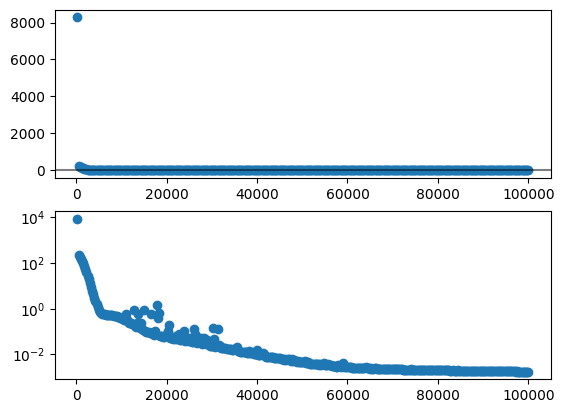

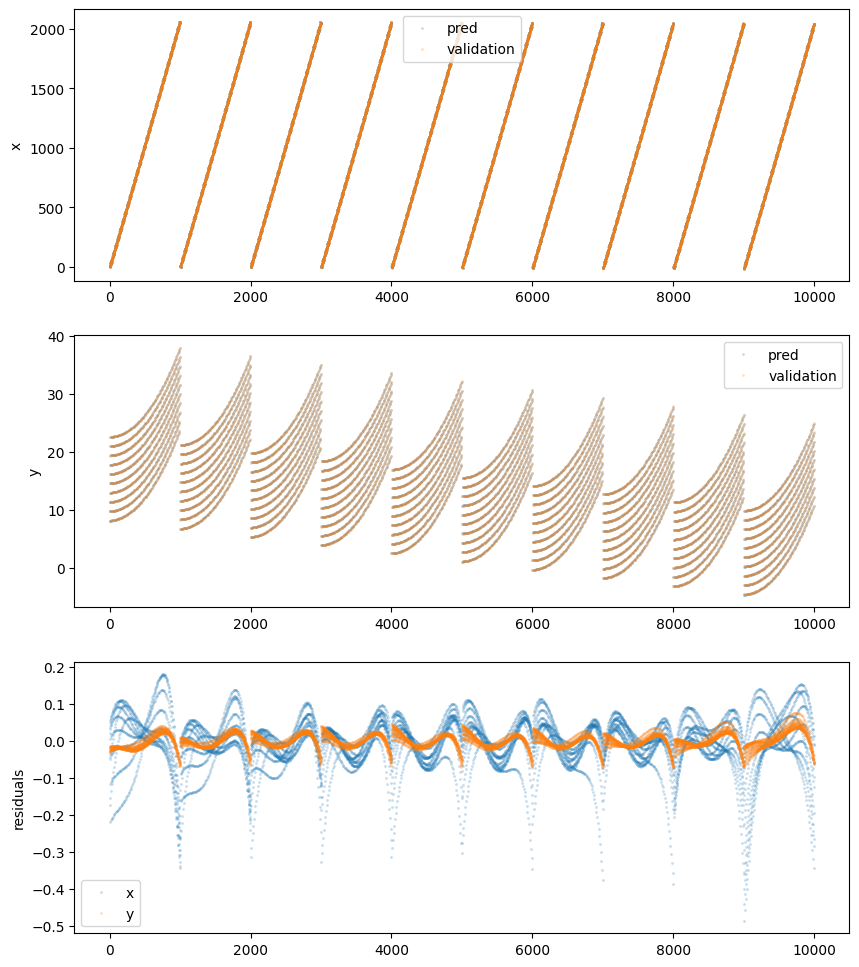

In [42]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

### Try adding the sigmoid

In [29]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()-10), float(valid_outs[...,i].max())+10) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=64, endsmooth=True), 
                           1024*25, 100000, log_period=250, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001})

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 215563.46875
lr updated to [0.001]
test loss at batch 250 is 2635.1181640625
test loss at batch 500 is 1978.5089111328125
test loss at batch 750 is 1898.388671875
test loss at batch 1000 is 1831.1785888671875
test loss at batch 1250 is 1782.6669921875
test loss at batch 1500 is 1751.50439453125
test loss at batch 1750 is 1728.89111328125
test loss at batch 2000 is 1694.1058349609375
test loss at batch 2250 is 1614.471923828125
test loss at batch 2500 is 1473.857666015625
test loss at batch 2750 is 1232.581298828125
test loss at batch 3000 is 913.5300903320312
test loss at batch 3250 is 621.9102172851562
test loss at batch 3500 is 431.1391906738281
test loss at batch 3750 is 337.7467956542969
test loss at batch 4000 is 297.1912841796875
test loss at batch 4250 is 275.5602722167969
test loss at batch 4500 is 259.5497131347656
test loss at batch 4750 is 246.1117401123047
test loss at batch 5000 is 234.7268524169922
test loss at batch 5250 is 225.400634765625
test l

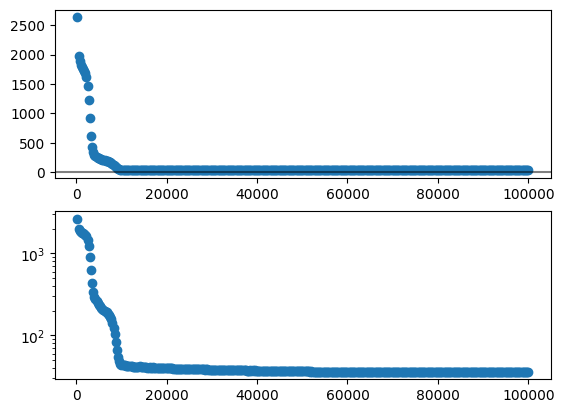

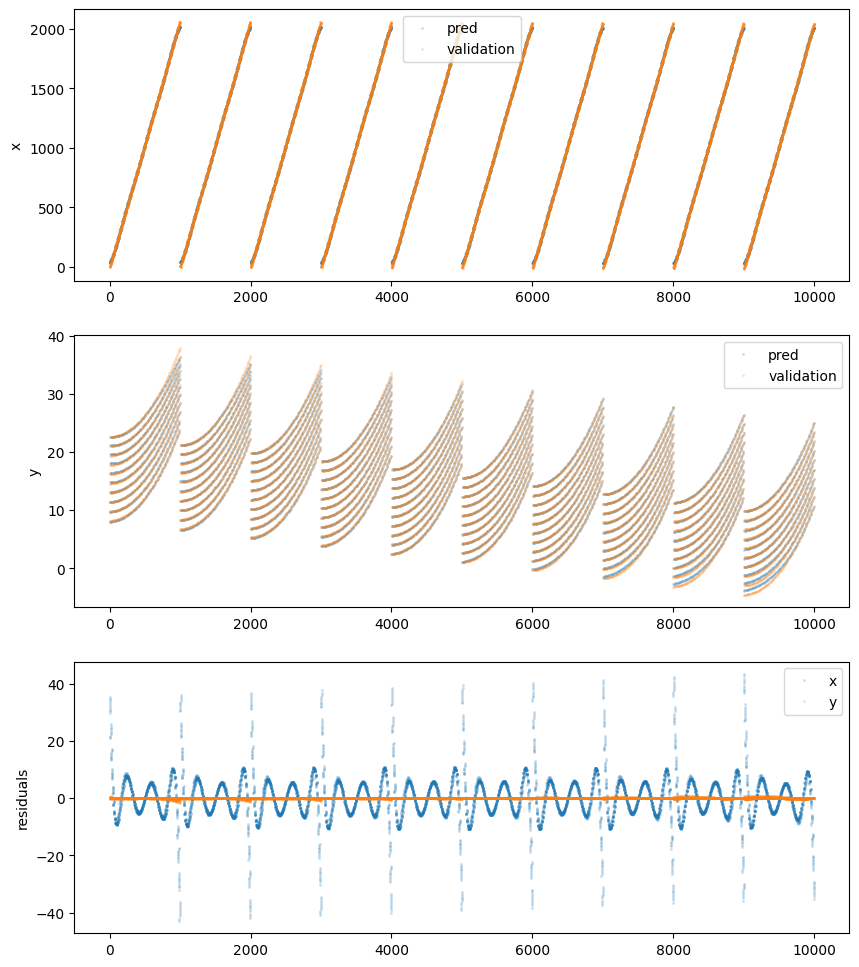

In [30]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [35]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()-10), float(valid_outs[...,i].max())+10) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256, endsmooth=True), 
                           1024*25, 100000, log_period=250, npregen=1024*1000, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001})

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 180265.78125
lr updated to [0.001]
test loss at batch 250 is 1754.920654296875
test loss at batch 500 is 1719.3826904296875
test loss at batch 750 is 1694.2698974609375
test loss at batch 1000 is 1657.592041015625
test loss at batch 1250 is 1553.7056884765625
test loss at batch 1500 is 1286.355712890625
test loss at batch 1750 is 860.8656005859375
test loss at batch 2000 is 507.0056457519531
test loss at batch 2250 is 355.3786315917969
test loss at batch 2500 is 313.8023681640625
test loss at batch 2750 is 296.5506591796875
test loss at batch 3000 is 282.8196105957031
test loss at batch 3250 is 270.4198913574219
test loss at batch 3500 is 258.9667663574219
test loss at batch 3750 is 248.78671264648438
test loss at batch 4000 is 239.8046875
test loss at batch 4250 is 232.7860107421875
test loss at batch 4500 is 226.21913146972656
test loss at batch 4750 is 220.23709106445312
test loss at batch 5000 is 216.14962768554688
test loss at batch 5250 is 211.769454956054

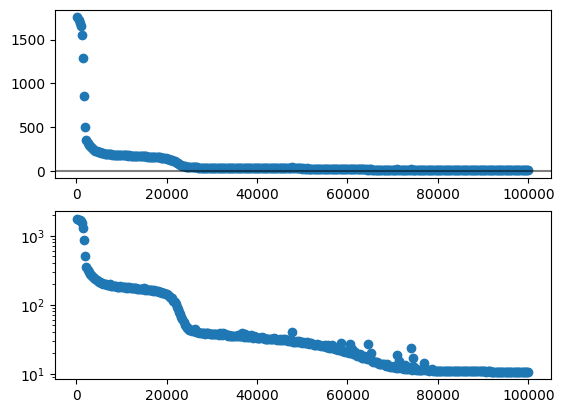

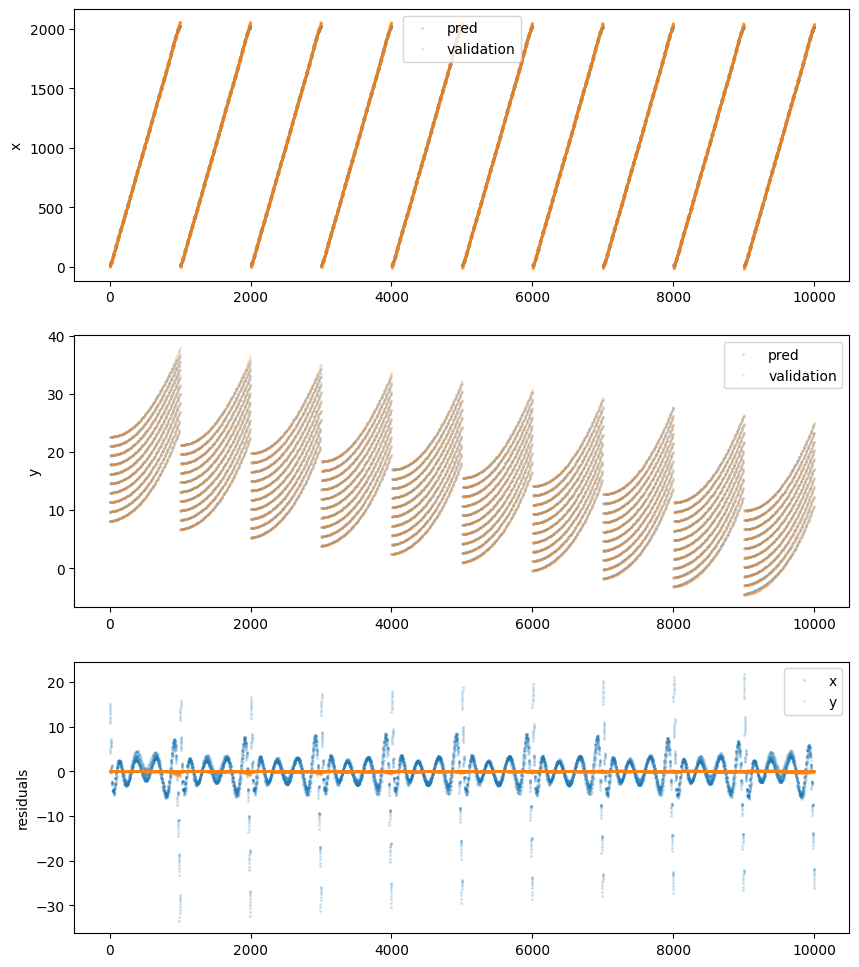

In [36]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

### Double-check match norm but with the rescaling

In [31]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=False, inner_layer_nneurons=256), 
                           1024*1000, 2500, log_period=250, npregen=1024*20000, perm=False, 
                           optimizer=dict(lr=5e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.2, 'threshold':.001})

  0%|          | 0/2500 [00:00<?, ?it/s]

test loss at batch 0 is 230093.8125
lr updated to [0.0005]
test loss at batch 250 is 272.5265808105469
test loss at batch 500 is 138.4076690673828
test loss at batch 750 is 57.42206954956055
test loss at batch 1000 is 22.278404235839844
test loss at batch 1250 is 9.477992057800293
test loss at batch 1500 is 4.498561382293701
test loss at batch 1750 is 2.2448575496673584
test loss at batch 2000 is 1.2040495872497559
test loss at batch 2250 is 0.7625200748443604
test loss at batch 2499 is 0.5938544869422913
CPU times: user 1min 58s, sys: 39.1 s, total: 2min 37s
Wall time: 2min 30s


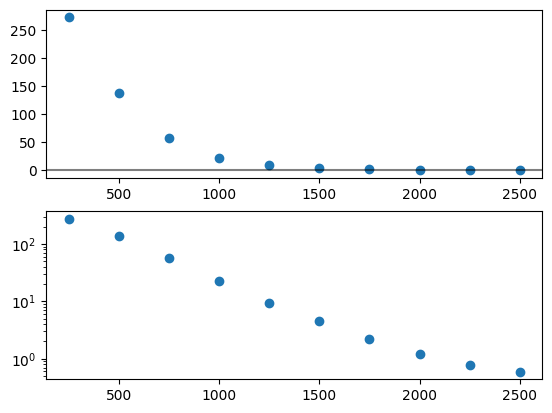

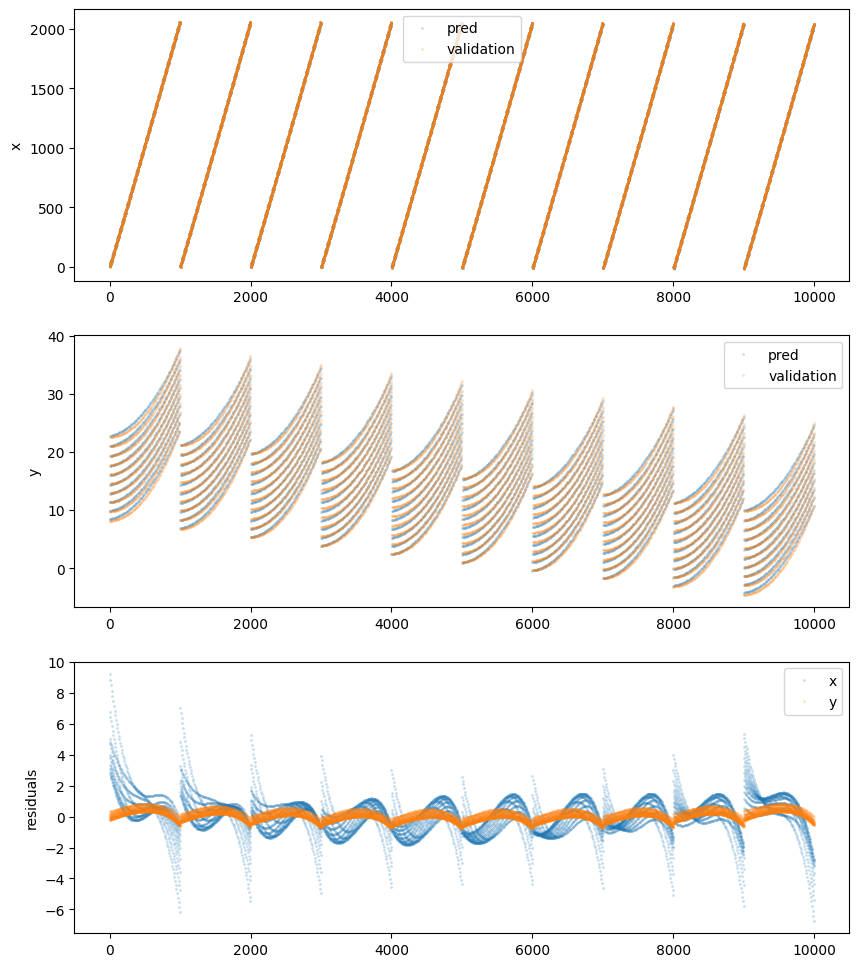

In [32]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)

In [33]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, batchnorm=True, inner_layer_nneurons=256), 
                           1024*1000, 2500, log_period=250, npregen=1024*20000, perm=False, 
                           optimizer=dict(lr=5e-4, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.2, 'threshold':.001})

  0%|          | 0/2500 [00:00<?, ?it/s]

test loss at batch 0 is 191454.984375
lr updated to [0.0005]
test loss at batch 250 is 106.87726593017578
test loss at batch 500 is 33.95503234863281
test loss at batch 750 is 13.070515632629395
test loss at batch 1000 is 6.3543901443481445
test loss at batch 1250 is 4.840676307678223
test loss at batch 1500 is 2.546477794647217
test loss at batch 1750 is 2.150965690612793
test loss at batch 2000 is 1.8775293827056885
test loss at batch 2250 is 1.3707287311553955
test loss at batch 2499 is 1.7662172317504883
CPU times: user 2min 45s, sys: 12.8 s, total: 2min 57s
Wall time: 2min 56s


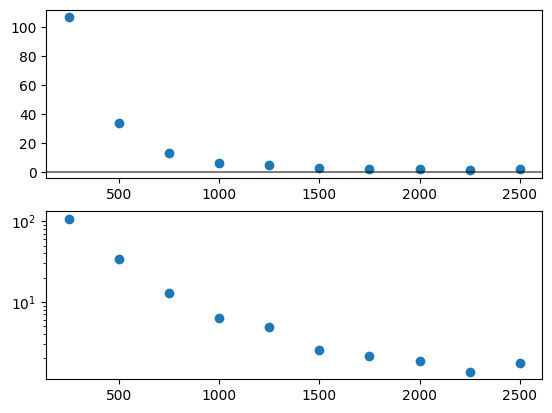

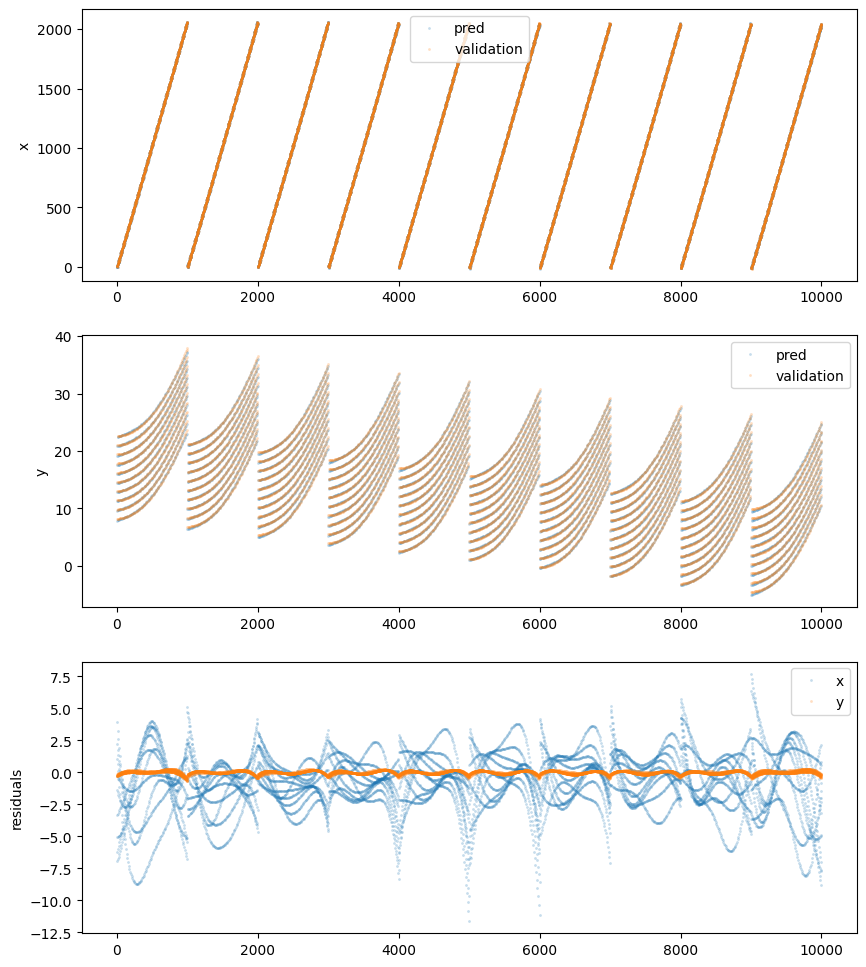

In [34]:
plot_model_run(*res);
fig = plot_model_results(res[0], maxpoints=None, alpha=.25, ms=2)